In [2]:
# Load packages
import numpy as np  
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

print "Read in packages from numpy, pandas, sklearn, seaborn & matplotlib"

Read in packages from numpy, pandas, sklearn, seaborn & matplotlib


In [3]:
# Load training data
dates_ = range(1, 22)
dates = ["{:02d}".format(item) for item in dates_] 

# Read in order data
order_train = pd.concat( pd.read_table('../../../../../../data/season_1/training_data/order_data/order_data_2016-01-%s' %i, header=None, names = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'Time' ])
                      for i in dates)

# Convert to datetime
order_train['Time'] = pd.to_datetime(order_train['Time'])  

# Read in poi data
poi_train = pd.read_table('../../../../../../data/season_1/training_data/poi_data/poi_data', sep=' ', header=None, names = ['district_hash'])
poi_train = pd.DataFrame(poi_train.district_hash.str.split('\W+',1).tolist(), columns = ['district_hash','poi_class'])

# Read in traffic data
traffic_train = pd.concat( pd.read_table('../../../../../../data/season_1/training_data/traffic_data/traffic_data_2016-01-%s' %i, sep=' ', header=None, names = ['district_hash_orig', 'time'])
                        for i in dates)

split1 = pd.DataFrame(traffic_train.district_hash_orig.str.split('[\W+]',1).tolist())
traffic_train['district_hash'] = split1[0]
traffic_train['tj'] = split1[1]

split2 = pd.DataFrame(traffic_train.tj.str.split('(\d{4}\-\d{2}\-\d{2}$)',1).tolist())
traffic_train['tj_level'] = split2[0]
traffic_train['date'] = split2[1]

traffic_train['Time'] = traffic_train.apply(lambda r: str(r.date) + ' '+ str(r.time), axis=1)
traffic_train.drop(['district_hash_orig', 'time', 'tj', 'date'], axis=1, inplace=True)

# Convert to datetime
traffic_train['Time'] = pd.to_datetime(traffic_train['Time'])

# Read in weather data                                                                                                                                                            
weather_train = pd.concat( pd.read_table('../../../../../../data/season_1/training_data/weather_data/weather_data_2016-01-%s' %i, header=None, names = ['Time', 'Weather', 'temperature', 'PM2.5' ])
                        for i in dates)                      

# Convert to datetime
weather_train['Time'] = pd.to_datetime(weather_train['Time']) 

# Review input features (ORDER, POI, TRAFFIC, WEATHER) for training set - Part 1
names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

for name, feature in zip(names, features):
    print "\n\n-----------------------"
    print "{} TRAIN INFORMATION" .format(str.upper(name))
    print "-----------------------"
    print "Shape of training set:", feature.shape, "\n\n"
    print "Column Headers:", list(feature.columns.values), "\n\n"
    print feature.dtypes, "\n\n"
    print feature.head(5), "\n\n"
    print feature.describe(), "\n\n"



-----------------------
ORDER TRAIN INFORMATION
-----------------------
Shape of training set: (8540614, 7) 


Column Headers: ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'Time'] 


order_id                       object
driver_id                      object
passenger_id                   object
start_district_hash            object
dest_district_hash             object
Price                         float64
Time                   datetime64[ns]
dtype: object 


                           order_id                         driver_id  \
0  97ebd0c6680f7c0535dbfdead6e51b4b  dd65fa250fca2833a3a8c16d2cf0457c   
1  92c3ac9251cc9b5aab90b114a1e363be  c077e0297639edcb1df6189e8cda2c3d   
2  abeefc3e2aec952468e2fd42a1649640  86dbc1b68de435957c61b5a523854b69   
3  cb31d0be64cda3cc66b46617bf49a05c  4fadfa6eeaa694742de036dddf02b0c4   
4  139d492189ae5a933122c098f63252b3                               NaN   

                       passenger_id       

In [4]:
# Load test data
dates = ('22_test', '24_test', '26_test', '28_test', '30_test')

# Load cluster map - generate dictionary to map district_hash to district_id
district = pd.read_table('../../../../../../data/season_1/test_set_1/cluster_map/cluster_map', sep=' ', header=None, names=['district_hash'])
district = pd.DataFrame(district.district_hash.str.split('\W+',1).tolist(), columns = ['district_hash', 'district_id'])
district_dict = district.set_index('district_hash')['district_id'].to_dict()

# Read in order data
order_test = pd.concat( pd.read_table('../../../../../../data/season_1/test_set_1/order_data/order_data_2016-01-%s' %i, header=None,
                                      names = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'Time' ])
                      for i in dates)

# Convert to datetime
order_test['Time'] = pd.to_datetime(order_test['Time'])   

# Read in poi data
poi_test = pd.read_table('../../../../../../data/season_1/test_set_1/poi_data/poi_data', sep=' ', header=None, names=['district_hash'])
poi_test = pd.DataFrame(poi_test.district_hash.str.split('\W+',1).tolist(), columns = ['district_hash','poi_class'])

# Read in traffic data
traffic_test = pd.concat( pd.read_table('../../../../../../data/season_1/test_set_1/traffic_data/traffic_data_2016-01-%s' %i, sep=' ',
                                        header=None, names = ['district_hash_orig', 'time'])
                        for i in dates)

split1 = pd.DataFrame(traffic_test.district_hash_orig.str.split('[\W+]',1).tolist())
traffic_test['district_hash'] = split1[0]
traffic_test['tj'] = split1[1]

split2 = pd.DataFrame(traffic_test.tj.str.split('(\d{4}\-\d{2}\-\d{2}$)',1).tolist())
traffic_test['tj_level'] = split2[0]
traffic_test['date'] = split2[1]

traffic_test['Time'] = traffic_test.apply(lambda r: str(r.date) + ' '+ str(r.time), axis=1)
traffic_test.drop(['district_hash_orig', 'time', 'tj', 'date'], axis=1, inplace=True)

# Convert to datetime
traffic_test['Time'] = pd.to_datetime(traffic_test['Time'])

# Read in weather data    
weather_test = pd.concat( pd.read_table('../../../../../../data/season_1/test_set_1/weather_data/weather_data_2016-01-%s' %i, 
                                        header=None, names = ['Time', 'Weather', 'temperature', 'PM2.5' ])
                        for i in dates) 

# Convert to datetime
weather_test['Time'] = pd.to_datetime(weather_test['Time'])                

# Review input features (ORDER, POI, TRAFFIC, WEATHER) for test set - Part 1
names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_test, poi_test, traffic_test, weather_test]

for name, feature in zip(names, features):
    print "\n\n-----------------------"
    print "{} TEST INFORMATION" .format(name)
    print "-----------------------"
    print "Shape of test set:", feature.shape, "\n\n"
    print "Column Headers:", list(feature.columns.values), "\n\n"
    print feature.dtypes, "\n\n"
    print feature.head(5), "\n\n"
    print feature.describe(), "\n\n"



-----------------------
ORDER TEST INFORMATION
-----------------------
Shape of test set: (557985, 7) 


Column Headers: ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'Time'] 


order_id                       object
driver_id                      object
passenger_id                   object
start_district_hash            object
dest_district_hash             object
Price                         float64
Time                   datetime64[ns]
dtype: object 


                           order_id                         driver_id  \
0  e37f842c2a37de68e16466a3c56b916b                               NaN   
1  62588e55ff8892ba38a0bbe5678be272  53919c82b12bd39b12d77d4d8db1dda1   
2  693194e4d57cdd500e793c0c1e4f7a93  19f5ba02d33855688b727e39c98b2939   
3  3a0c651d2558d9083a66fc179e3ba81c                               NaN   
4  68b7cec210c7f875b79ce32dab7195ea                               NaN   

                       passenger_id             

In [5]:
# Review input features for train set - Part 2
missing_values = []
nonumeric_values = []

names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

print ("TRAIN SET INFORMATION")
print ("========================\n")

for name,feature in zip(names,features):
    
    print "\n-----------------------"
    print "{} TRAIN INFORMATION" .format(name)
    print "-----------------------\n"
    missing_values = []
    nonumeric_values = []
    
    for column in feature:
        
        # Find all the unique feature values
        uniq = feature[column].unique()
        print ("'{}' has {} unique values" .format(column,uniq.size))
        if (uniq.size > 25):
            print("~~Listing up to 25 unique values~~")
        print (uniq[0:24])
        print ("\n-----------------------------------------------------------------------\n")
            
        # Find features with missing values
        if (True in pd.isnull(uniq)):
            s = "{} has {} missing" .format(column, pd.isnull(feature[column]).sum())
            missing_values.append(s)
    
        # Find features with non-numeric values
        for i in range (1, np.prod(uniq.shape)):
            
            if (re.match('nan', str(uniq[i]))):
                break
            
            if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
                nonumeric_values.append(column)
                break
  
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print ("{} Features with missing values:\n{}\n\n" .format(name, missing_values))
    print ("{} Features with non-numeric values:\n{}" .format(name, nonumeric_values))
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

TRAIN SET INFORMATION


-----------------------
ORDER TRAIN INFORMATION
-----------------------

'order_id' has 8518049 unique values
~~Listing up to 25 unique values~~
['97ebd0c6680f7c0535dbfdead6e51b4b' '92c3ac9251cc9b5aab90b114a1e363be'
 'abeefc3e2aec952468e2fd42a1649640' 'cb31d0be64cda3cc66b46617bf49a05c'
 '139d492189ae5a933122c098f63252b3' 'b0b59fd0fe98bf603972da2f62e6522d'
 '17c1c85144ab532947c7ea724fdcc945' 'd682c1c004024f8937d21cd43498d1bb'
 '6fcae38baf2eb52e17273df41bf6fc6f' '70afc52be8a6d35137f2277a6ca88017'
 '29251671fcc9d9078b760ce3f6f7994b' 'ef10162b38fadcd75a5751bebe450f13'
 '23d8b4bd3443c32d5c08821943b9e779' '1b3b4b633578f88325973e084450af6f'
 '367da7c50e897ef8c11e5f103ca857b8' '1ec11c9499014c583995adfc1198da8d'
 '180470cf2f166e7251daaf8502fee301' 'c9a59b617813c106ea7c8809f5127811'
 'd0341ac9950c029e2ef6212628a94900' 'bf9fcd57aa98208c11de945513e26cce'
 '9a13aebfdf99847fd502815271e45a01' '0dd9ca15cbc2168e07ef61df4f9b6dda'
 '85bcc0e17b9a54454625a4ca1082f412' '7601a5eaee305

In [6]:
# Review input features for test set - Part 2
missing_values = []
nonumeric_values = []

names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_test, poi_test, traffic_test, weather_test]

print ("TEST SET INFORMATION")
print ("========================\n")

for name,feature in zip(names,features):
    
    print "\n-----------------------"
    print "{} TEST INFORMATION" .format(name)
    print "-----------------------\n"
    missing_values = []
    nonumeric_values = []
    
    for column in feature:
        
        # Find all the unique feature values
        uniq = feature[column].unique()
        print ("'{}' has {} unique values" .format(column,uniq.size))
        if (uniq.size > 25):
            print("~~Listing up to 25 unique values~~")
        print (uniq[0:24])
        print ("\n-----------------------------------------------------------------------\n")
            
        # Find features with missing values
        if (True in pd.isnull(uniq)):
            s = "{} has {} missing" .format(column, pd.isnull(feature[column]).sum())
            missing_values.append(s)
    
        # Find features with non-numeric values
        for i in range (1, np.prod(uniq.shape)):
            
            if (re.match('nan', str(uniq[i]))):
                break
            
            if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
                nonumeric_values.append(column)
                break
  
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print ("{} Features with missing values:\n{}\n\n" .format(name, missing_values))
    print ("{} Features with non-numeric values:\n{}" .format(name, nonumeric_values))
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

TEST SET INFORMATION


-----------------------
ORDER TEST INFORMATION
-----------------------

'order_id' has 556729 unique values
~~Listing up to 25 unique values~~
['e37f842c2a37de68e16466a3c56b916b' '62588e55ff8892ba38a0bbe5678be272'
 '693194e4d57cdd500e793c0c1e4f7a93' '3a0c651d2558d9083a66fc179e3ba81c'
 '68b7cec210c7f875b79ce32dab7195ea' '6f34f29e68d317e3ca6dbd9ebeb24d5b'
 'e502c5addc7ccae08e6d8c2b5146cdb4' 'e56eeb16aaa407faab11732a5feda7fd'
 '6bd4f5447add2c3002656897f95c96d6' '9aefc579a9372ee293d584912b847cc5'
 '340a55eb95558104b496f562d865121b' 'dcddad7a414b0db2896d3571c9435dc8'
 '93f8022a1076295847597b1d1bcbbd78' 'fd52e9101d14c221ebc75aa79d39b673'
 '0593f172ee33c172142da384b567887b' 'feff7411b44fea2a6bd8da2ad4932803'
 '7feed561a986c5f579248cf818e96767' '4e6517efdcdad1ab5c6b016ca856639d'
 '4dd56b45a6f68af822da1be742704e90' 'ea6655f094e34868681747eb2bc1ce19'
 '0e9c8771c221ad21704551348ed2b1ef' '4c1cce63533b275e83b4e5d2b10e5899'
 'd3e0884b1d0eec7d702ea509c4f108ec' '2ebd0a61b632c919

In [7]:
######### FUNCTION DEFINITIONS ####################################################
# Map district_hash to district_id
def dist_hash2id(data_frame, hash_col, district_dict):
    idvalue_array = []
    
    for hash_value in data_frame[hash_col]:
        idvalue_array.append(district_dict[hash_value])
    
    return idvalue_array

# Map time_stamp to time_slot
def time_stamp2slot(arr_hour, arr_minute, arr_second):
    time_slot = []
    
    for hour, minu, sec in zip(arr_hour, arr_minute, arr_second):
        time_slot.append(int((6*hour + 0.1*minu + sec/600) + 1))
    
    return time_slot

# Combine num_day and time_slot to create time_axis
def time_axis(num_day, time_slot):
    return (((num_day - 1)*144) + time_slot)


# Calculate demand, supply and gap per time axis slot
# Demand = Number of orders received (ride requests)
# Supply = Number of orders answered
# Gap = Number of orders missed (NA)
def demand_supply(order_frame):
    
    demand = {}
    supply = {}
    gap = {}
    
    # Initialize demand & supply to zero
    for district in range(1,67):
        for time in range(1,31*144):
            demand[(district, time)] = 0;
            supply[(district, time)] = 0;

    # Iterate over all orders to accumulate demand, supply count for each time slot
    for district_id, num_day, time_slot, answered in zip(order_frame['district_id'], order_frame['num_day'], 
                                                         order_frame['time_slot'], order_frame['driver_id']):
        demand[(int(district_id),time_axis(num_day, time_slot))] += 1;
        supply[(int(district_id),time_axis(num_day, time_slot))] += pd.notnull(answered);
        
    # Calculate the demand-supply gap
    for district in range(1,67):
        for time in range(1,31*144):
            gap[(district, time)] = demand[(district, time)] - supply[(district, time)];
    
    return (demand, supply, gap)

In [8]:
####################        TRAINING DATA       #############################
# Update ORDER
# IGNORING: order_id, driver_id, passenger_id

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
order_train.set_index('Time', inplace=True)

order_train['num_day'] = order_train.index.day
order_train['time_slot'] = time_stamp2slot(order_train.index.hour, order_train.index.minute, order_train.index.second)

order_train.reset_index(inplace='True')

order_train['week_day'] = order_train['Time'].dt.dayofweek

# Map start_district_hash (1...66)
order_train['district_id'] = dist_hash2id(order_train, 'start_district_hash', district_dict)

# Calculate demand, supply & gap for all district_id & time_slot
d_train = {}
s_train = {}
g_train = {}
d_train, s_train, g_train = demand_supply(order_train)

# Map end_district_hash (1...381)

###################################################################################
# Update POI

# Map district_hash (1...66) to district_id
poi_train['district_id'] = dist_hash2id(poi_train, 'district_hash', district_dict)

# Create sub features for poi_class

###################################################################################
# Update TRAFFIC

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
traffic_train.set_index('Time', inplace=True)

traffic_train['num_day'] = traffic_train.index.day
traffic_train['time_slot'] = time_stamp2slot(traffic_train.index.hour, traffic_train.index.minute, traffic_train.index.second)

traffic_train.reset_index(inplace='True')

traffic_train['week_day'] = traffic_train['Time'].dt.dayofweek

# Map district_hash (1...66) to district_id
traffic_train['district_id'] = dist_hash2id(traffic_train, 'district_hash', district_dict)

# Create sub features for tj_level

###################################################################################
# Update WEATHER

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
weather_train.set_index('Time', inplace=True)

weather_train['num_day'] = weather_train.index.day
weather_train['time_slot'] = time_stamp2slot(weather_train.index.hour, weather_train.index.minute, weather_train.index.second)

weather_train.reset_index(inplace='True')

weather_train['week_day'] = weather_train['Time'].dt.dayofweek

In [9]:
#######################        TEST DATA        ##############################
# Update ORDER
# IGNORING: order_id, driver_id, passenger_id

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 

order_test.set_index('Time', inplace=True)

order_test['num_day'] = order_test.index.day
order_test['time_slot'] = time_stamp2slot(order_test.index.hour, order_test.index.minute, order_test.index.second)

order_test.reset_index(inplace='True')

order_test['week_day'] = order_test['Time'].dt.dayofweek

# Map start_district_hash (1...66)
order_test['district_id'] = dist_hash2id(order_test, 'start_district_hash', district_dict)

# Calculate demand, supply & gap for all district_id & time_slot
d_test = {}
s_test = {}
g_test = {}
d_test, s_test, g_test = demand_supply(order_test)

# Map end_district_hash (1...381)

###################################################################################
# Update POI

# Map district_hash (1...66) to district_id
poi_test['district_id'] = dist_hash2id(poi_test, 'district_hash', district_dict)

# Create sub features for poi_class

###################################################################################
# Update TRAFFIC

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
traffic_test.set_index('Time', inplace=True)

traffic_test['num_day'] = traffic_test.index.day
traffic_test['time_slot'] = time_stamp2slot(traffic_test.index.hour, traffic_test.index.minute, traffic_test.index.second)

traffic_test.reset_index(inplace='True')

traffic_test['week_day'] = traffic_test['Time'].dt.dayofweek

# Map district_hash (1...66) to district_id
traffic_test['district_id'] = dist_hash2id(traffic_test, 'district_hash', district_dict)

# Create sub features for tj_level

###################################################################################
# Update WEATHER

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
weather_test.set_index('Time', inplace=True)

weather_test['num_day'] = weather_test.index.day
weather_test['time_slot'] = time_stamp2slot(weather_test.index.hour, weather_test.index.minute, weather_test.index.second)

weather_test.reset_index(inplace='True')

weather_test['week_day'] = weather_test['Time'].dt.dayofweek

In [10]:
# Create train_set
train_set = pd.DataFrame()

for district in range(1,67):
    # Skip Jan 1 (Holiday)
    for day in range(2,22):
        for time in range(1,145):
            data = {'district_id': [district], 'num_day': [day], 'time_slot': [time],
                    'week_day': [(day+3)%7],
                    'demand': d_train[(district,time_axis(day,time))],
                    'gap': g_train[(district,time_axis(day,time))]
                   }
            df = pd.DataFrame(data, columns=['district_id', 'num_day', 'time_slot', 'week_day', 'demand', 'gap'])
            train_set = train_set.append(df)

In [11]:
print "Shape of test set:", train_set.shape, "\n\n"
print "Column Headers:", list(train_set.columns.values), "\n\n"
print train_set.dtypes, "\n\n"
print train_set.head(5), "\n\n"
print train_set.describe(), "\n\n"

Shape of test set: (190080, 6) 


Column Headers: ['district_id', 'num_day', 'time_slot', 'week_day', 'demand', 'gap'] 


district_id    int64
num_day        int64
time_slot      int64
week_day       int64
demand         int64
gap            int64
dtype: object 


   district_id  num_day  time_slot  week_day  demand  gap
0            1        2          1         5      88    3
0            1        2          2         5      97    7
0            1        2          3         5      75    5
0            1        2          4         5      60    2
0            1        2          5         5      72    7 


         district_id        num_day      time_slot       week_day  \
count  190080.000000  190080.000000  190080.000000  190080.000000   
mean       33.500000      11.500000      72.500000       2.950000   
std        19.050422       5.766296      41.568326       2.036547   
min         1.000000       2.000000       1.000000       0.000000   
25%        17.000000       6.750000    

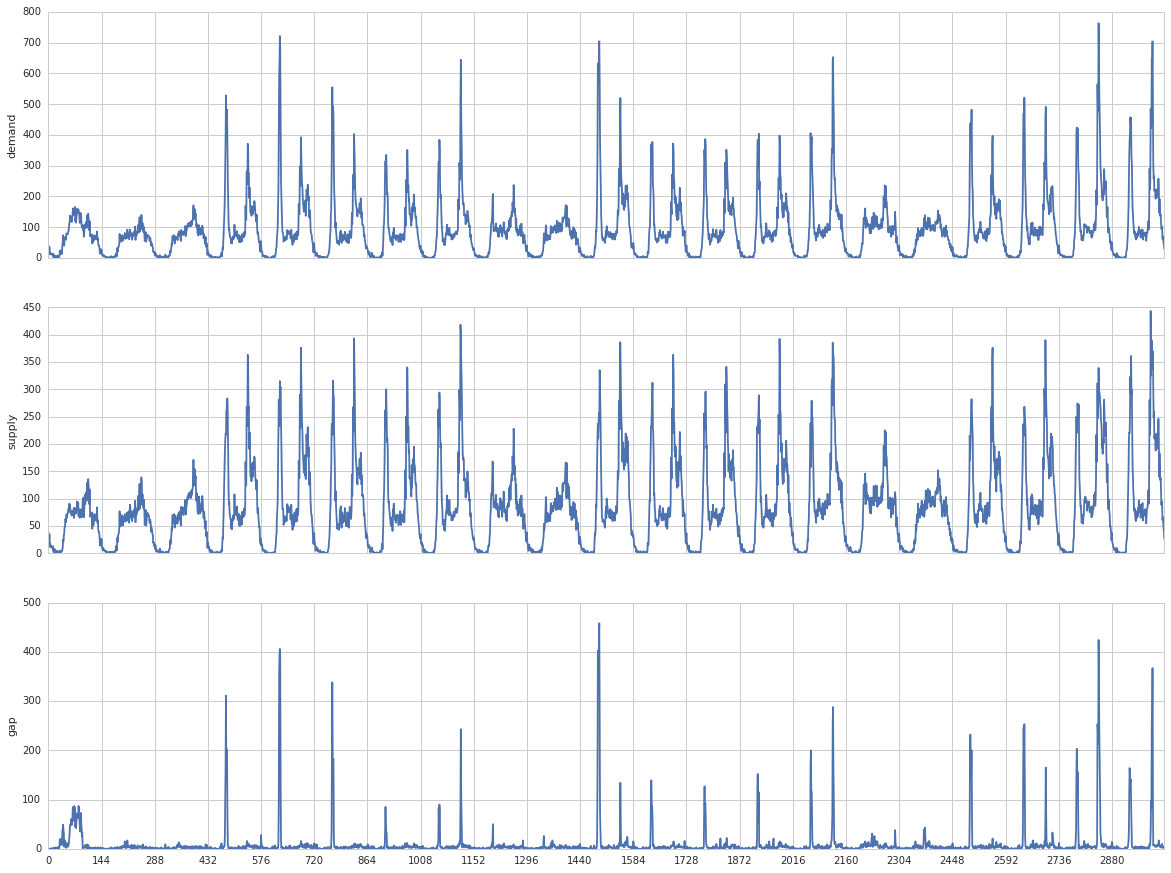

In [12]:
# Plot training data: d, s, g
dplot = []
splot = []
gplot = []

trange   = range(1,21*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d_train[(20,t)])
    splot.append(s_train[(20,t)])
    gplot.append(g_train[(20,t)])

f, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(20,15))
plt.xlim(0, pltrange)
ax1.grid(True)
#ax1.set_yticks(np.arange(0,160,20))
ax1.set_xticks(np.arange(0, pltrange,144))
    
sns.tsplot(data=dplot, ax=ax1, value="demand")
sns.tsplot(data=splot, ax=ax2, value="supply")
sns.tsplot(data=gplot, ax=ax3, value="gap")

In [1]:
# Assess Feature importance

# Train / Test split for original training data
# Withold 15% from train set for testing
predictors = ['district_id', 'num_day', 'time_slot', 'week_day', 'demand']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    train_set[predictors], train_set['gap'], test_size=0.15, random_state=0)

print ("Original Training Set: {}\nTraining Set: {}\nTesting Set(witheld): {}" .format(train_set.shape, X_train.shape,X_test.shape))


# Normalize features - both training & test (withheld & final)
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
##VRfinal_test_transformed  = scaler.transform(test_set[predictors])

print ("Transformed training, test sets (withheld & final)")

# Scoring Metric - MSE
print ("Use MSE as the score function")

# Initialize the algorithm
# Defaults to mean square error as score
X_train1 = np.delete(X_train_transformed, [7,8], axis=1)

alg = RandomForestRegressor(random_state=1, n_estimators=10000, min_samples_split=50,
                            min_samples_leaf=1, n_jobs=-1)
clf = alg.fit(X_train1, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = ['district_id', 'num_day', 'time_slot', 'week_day', 'demand']
for f in range(X_train1.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [ feature_labels[i] for i in indices]
    
plt.title('Feature Importances')
plt.bar(range(X_train1.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X_train1.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train1.shape[1]])
plt.tight_layout()
plt.show()

NameError: name 'cross_validation' is not defined

In [ ]:
# Scores
train_score = clf.score(X_train_transformed, y_train)
test_score  = clf.score(X_test_transformed, y_test)
print ("Train Score: %0.3f\nTest Score: %0.3f" %(train_score, test_score))

In [ ]:
# Read in final_test df, scale features, generate predictions & write result file
# Load readme - generate final_test df
final_test = pd.read_table('../../../../../../data/season_1/test_set_1/read_me_1.txt', sep=' ', header=None, names=['time_stamp'])
final_test = pd.DataFrame(final_test.time_stamp.str.split('-').tolist(), columns = ['year', 'month', 'day', 'time_slot'])


day_test = final_test['day']
time_test = final_test['time_slot']


# Create train_set
test_set = pd.DataFrame()

for district in range(1,67):
    for day, time in zip(day_test, time_test):
        data = {'district_id': [district], 'num_day': [day], 'time_slot': [time],
                'week_day': [(day+3)%7],
                'demand': d_train[(district,time_axis(day,time))],
                'gap': g_train[(district,time_axis(day,time))]
                }
        df = pd.DataFrame(data, columns=['district_id', 'num_day', 'time_slot', 'week_day'])
        test_set = train_set.append(df)

predictors = ['district_id', 'num_day', 'time_slot', 'week_day']

# Feature scaling
test_transformed  = scaler.transform(test_set[predictors])

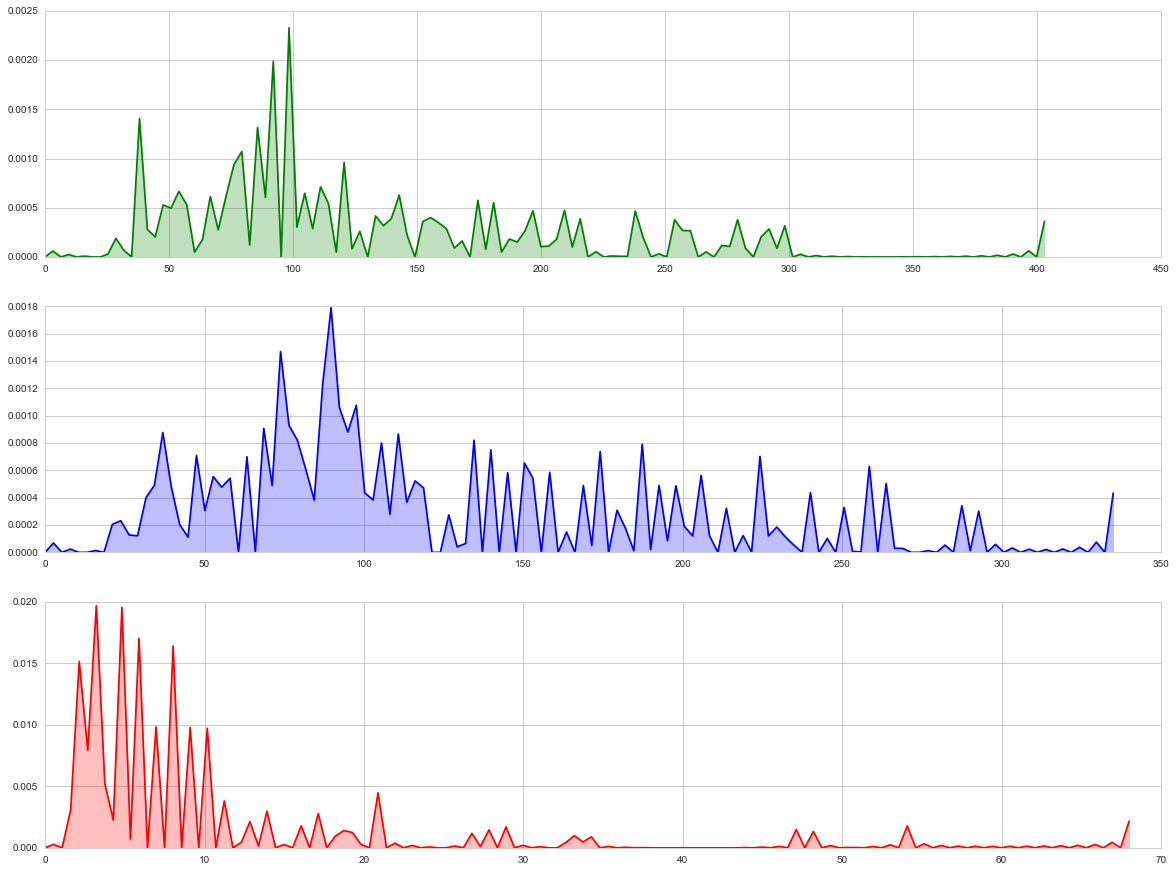

In [11]:
d_test = {}
s_test = {}
g_test = {}
d_test, s_test, g_test = demand_supply(order_test)

# Plot a distribution plot
dist = range(15,30)
time = range(21*144,31*144)

dplot = []
splot = []
gplot = []
for t in range(21*144,31*144):
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])

f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=False, figsize=(20,15))

sns.distplot(dplot, hist=False, color="g", kde_kws={"shade": True}, ax=axis1)
sns.distplot(splot, hist=False, color="b", kde_kws={"shade": True}, ax=axis2)
sns.distplot(gplot, hist=False, color="r", kde_kws={"shade": True}, ax=axis3)

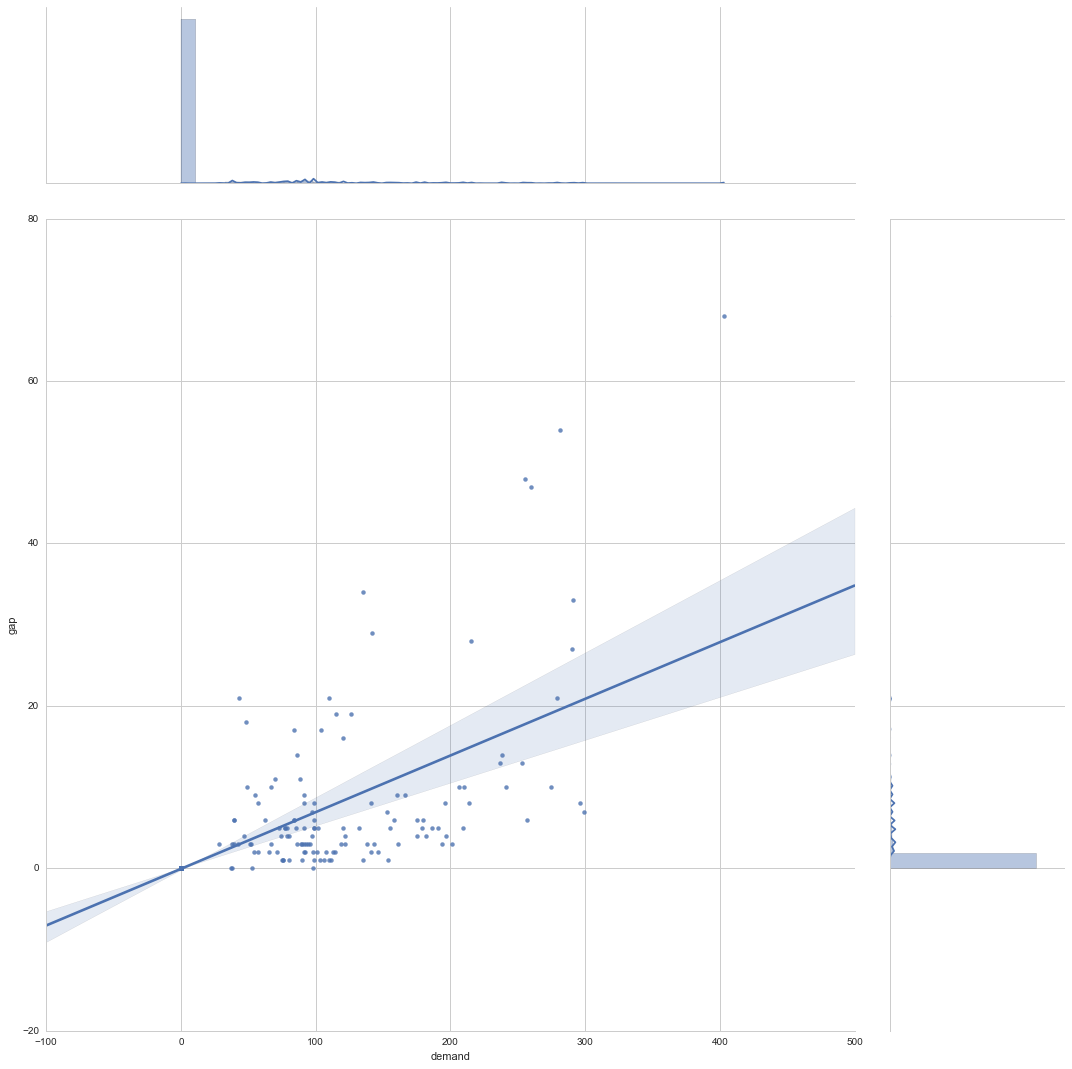

In [12]:
data = {'demand': dplot, 'gap': gplot}
df = pd.DataFrame(data, columns=['demand', 'gap'])

grid = sns.JointGrid(x='demand', y='gap', data=df, size=15, ratio=4)
grid = grid.plot(sns.regplot, sns.distplot)

 ...]

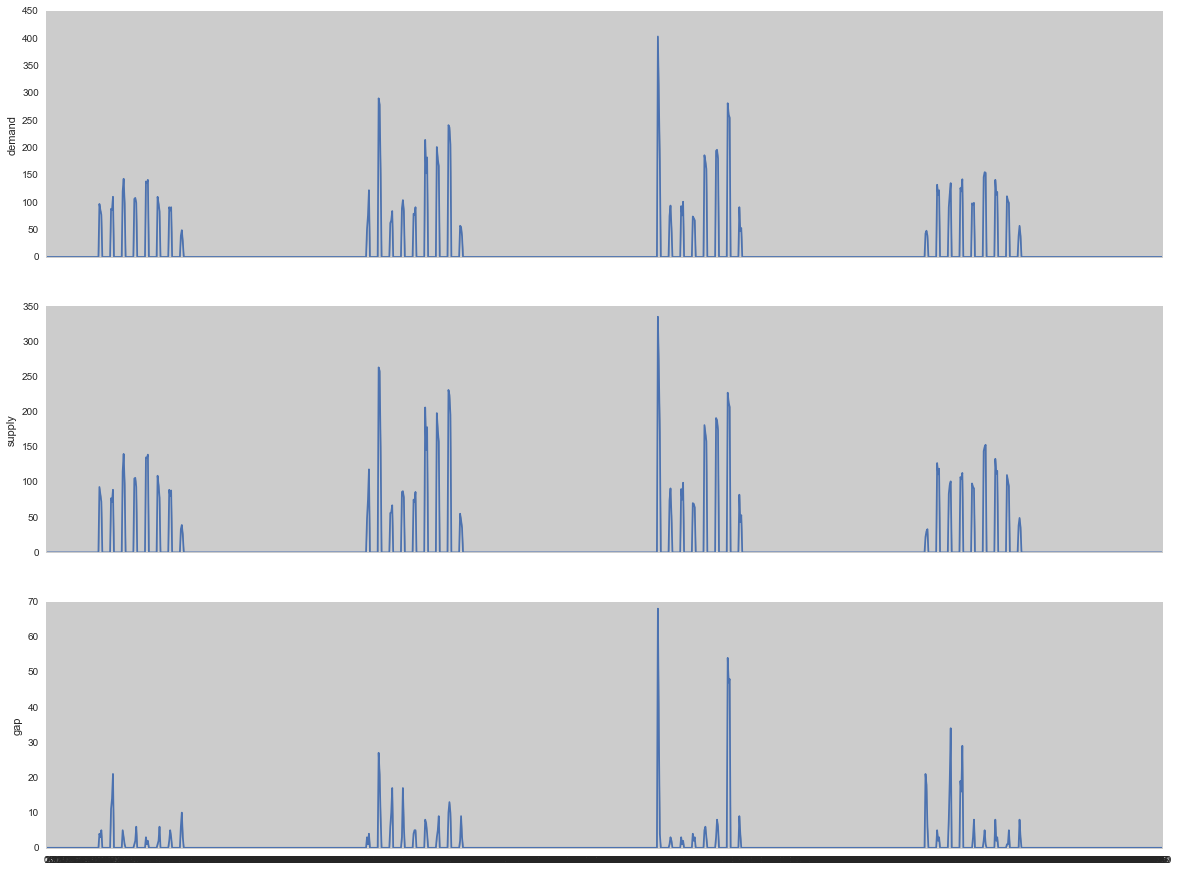

In [44]:
#plot test data
dplot = []
splot = []
gplot = []

trange   = range(23*144,31*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])
    
f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=True, figsize=(20,15))

sns.tsplot(data=dplot, ax=axis1, value="demand")
sns.tsplot(data=splot, ax=axis2, value="supply")
sns.tsplot(data=gplot, ax=axis3, value="gap")

plt.xlim(0, pltrange)

axis1.grid(True)

#axis1.set_yticks(np.arange(0,160,20))
axis1.set_xticks(np.arange(0, pltrange,1))

In [ ]:
sns.set(style="ticks")

# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)
df = pd.DataFrame(np.c_[pos.flat, step, walk],
                  columns=["position", "step", "walk"])

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="walk", hue="walk", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)